In [1]:
#Importing the required libraries
import cv2
import numpy as np
import os

In [2]:
#Loading the Haar Cascade Classifier for face detection
detector = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [3]:
#Sau khi giải nén video thành các frame, ta phải cắt các khuôn mặt trong các frame đó
id = 2
if id == 2:
    print(0)
    for i in range(1, 4):
        for j in range(0, 22):
            #Đọc file ảnh
            filename = 'Dataset_frame_extract\\Data\\anh.'+str(i)+'.'+str(j)+'.png'
            #Đọc ảnh
            frame = cv2.imread(filename)
            #Chuyển ảnh sang ảnh xám
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            #Phát hiện khuôn mặt
            fa = detector.detectMultiScale(gray, 1.1, 5)
            #Vẽ hình chữ nhật quanh khuôn mặt
            for (x, y, w, h) in fa:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                if not os.path.exists('dataset'):
                    os.makedirs('dataset')
                #lưu ảnh khuôn mặt
                cv2.imwrite('dataset\\anh.'+str(i)+'.'+str(j)+'.png', gray[y:y+h, x:x+w])

0


In [4]:
#sau cắt khuôn mặt, setup các thông số để train model
data = []
label = []
for i in range(1, 4):
    for j in range(0, 22):
        #Đọc ảnh
        filename = 'dataset\\anh.'+str(i)+'.'+str(j)+'.png'
        img = cv2.imread(filename)
        #Chuyển ảnh sang ảnh xám
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #Resize ảnh về kích thước 64x64
        img = cv2.resize(img, (64, 64))
        #Thêm ảnh vào data
        data.append(img)
        #Thêm nhãn vào label
        label.append(i-1)
#Chuyển data và label thành mảng numpy
data_np = np.array(data)
label_np = np.array(label)
data_np = data_np.reshape(data_np.shape[0], 64, 64, 1)
#Chuẩn hóa data - chia cho 255 vì giá trị pixel nằm trong khoảng 0-255
X_train = data_np/255
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
Y_train = lb.fit_transform(label_np)

In [6]:
print(X_train.shape)
print(Y_train.shape)

(66, 64, 64, 1)
(66, 3)


In [7]:
#apply model
nn = EnhancedNeuralNetwork()
X_train = X_train.reshape(X_train.shape[0], -1).T
Y_train = np.argmax(Y_train, axis=1)
W1, b1, W2, b2, W3, b3 = nn.gradient_descent(X_train, Y_train, 0.1, 1000)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
#Printing the accuracy
Z1, A1, Z2, A2 = nn.forward_prop(W1, b1, W2, b2, X_train.reshape(X_train.shape[0], 4096).T)
predictions = nn.get_predictions(A2)
accuracy = nn.get_accuracy(predictions, label_np)
print("Accuracy: ", accuracy)

Accuracy:  0.3333333333333333


In [ ]:
#Let's try other models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train_flatten = X_train.reshape(X_train.shape[0], 4096)

X_train, X_test, Y_train, Y_test = train_test_split(X_train_flatten, label_np, test_size=0.2, random_state=42)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = lr.predict(X_test)
print("Accuracy: ", np.mean(y_pred == Y_test))

Accuracy:  1.0


In [ ]:
#Thử với model dạng cây
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test)
print("Accuracy: ", np.mean(y_pred_rf == Y_test))

Accuracy:  1.0


[1]
[1]


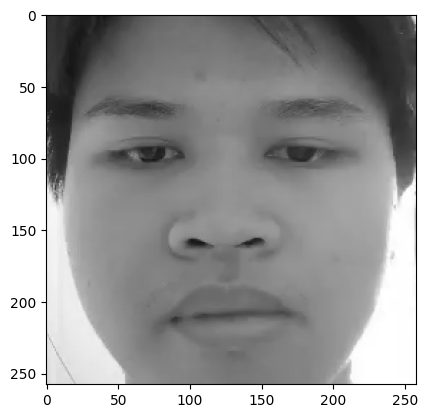

In [ ]:
#Build a prediction program
def predict(image):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (64, 64))
    img = img/255
    img = img.reshape(1, 64, 64, 1)
    prediction = nn.get_predictions(nn.forward_prop(W1, b1, W2, b2, img.reshape(1, 4096).T)[3])
    return prediction

#Test the prediction program
print(predict('dataset\\anh.1.0.png'))
print(predict('dataset\\anh.2.0.png'))

#Show image
import matplotlib.pyplot as plt
img = cv2.imread('dataset\\anh.1.0.png')
plt.imshow(img)
plt.show()

In [ ]:
#Tracking video
cap = cv2.VideoCapture('Dataset_frame_extract\\Dataset_video\\Quốc_Đạt.mp4')
cap.set(cv2.CAP_PROP_FPS, 30)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector.detectMultiScale(gray, 1.1, 5)
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (64, 64))
        face = face/255
        face = face.reshape(1, 64, 64, 1)
        prediction = predict(face)
        cv2.putText(frame, 'ID: '+str(prediction[0]+1), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Face Recognition', frame)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
#Display the video
cap = cv2.VideoCapture('Dataset_frame_extract\\Dataset_video\\Quốc_Đạt.mp4')
cap.set(cv2.CAP_PROP_FPS, 30)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) == ord('q'):
        break